# Final drone analysis (Rafael Stern and Jonathan Muller)

## This script is aimed to do a final analysis of the drone thermal images segmentation performed by Lior Segev's work

Lior provided a csv file for each flight, each 3 lines representing the segmentation of one picture into the objects: PV panels (panel), sun-lit soil (soil), shadded soil (shadow), and in some cases, sun spots reflected by the panels (sun). These lines contain the average of all pixels of each picture for the different radiation components.

- The main output of this script should be LWout_drone values which will replace the LWout_mast values, because the truck's mast was set-up in a low height, providing an insufficient fetch.

- The drone thermal camera basic output is APPARENT TEMPERATURE, using Emissivity = 1 and transmissivity = 1

There are 2 main uncertainties:

1. Real atmospheric transmissivity (between the object and the drone camera)
2. Different radiation ranges: drone (8 - 14 micrometers), mast LW sensor (4 - 50 micrometers)

Note regarding emissivities:

It is better to use the specific angular emissivity which the soil and panels are in relation to the camera, with 10 degrees of variation, instead of the "hemispherical emissivity", which is an integration of all the angles.

PV panels: 0.83 - the emissivity of 0.84 was determined and later changed in the script, with a proper explanation.

Soil: 0.89 - but then it was changed to 0.87, as explained in the script.

Based on Irina Vishnevetsky emissivity experiment.

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal

In [2]:
# Input and output paths
project_path_jul19 = 'F:/Group members Rafael/Analyses/Ketura Solar/Lior segmentation analysis/July 2019/thermal/'
project_path_oct18 = 'F:/Group members Rafael/Analyses/Ketura Solar/Lior segmentation analysis/October 2018/thermal/'

output_path = 'F:/Group members Rafael/Analyses/Ketura Solar/Lior segmentation analysis/Output/'

## Functions

In [3]:
def read_flight_data(input_fn, folder_fn):
    df = pd.read_csv(input_fn)
    df['flight'] = folder_fn
    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y:%m:%d %H:%M:%S')
    return(df)

def read_all_files(path):
    # List all files in the directories
    folder_list = sorted(glob.glob(path + '*/'))

    saved = []
    for folder_i, folder in enumerate(folder_list):
        folder_name = folder.split('\\')[-2]
        if(folder_name[0].isnumeric()):
            input_fn = folder + 'analysis/' + folder_name + '_thermal_analysis.csv'
            #print(folder_name, input_fn)
            temp = read_flight_data(input_fn, folder_name)
            # If there is no df (if we just started to read data), then create df
            if(folder_i == 0):
                df = temp
            else: # Otherwise, add data to df
                df = df.append(temp)
    return(df)


def correcting_mast_LWin(df):    
    # Correcting LW sensors of the truck's mast based on the SW effect. 
    # In this case, will be applied only to the LWin, since the LWout is estimated from the drone.
    # According to the equation calculated in the script "SW effect on LW sensors"
    # df['delta_LW_calc'] = -0.38 + 0.01*df['SW_no_shd'] 
    # df['LW_corr'] = df['LW_no_shd'] - df['delta_LW_calc']
    
    df.rename(columns={'LWin_W+1m-2': 'LWin_W+1m-2_old'}, inplace=True)
    #df.rename(columns={'LWout_W+1m-2': 'LWout_W+1m-2_old'}, inplace=True)
        
    df['delta_LWin_calc'] = -0.38 + 0.01*df['SWin_W+1m-2']
    df['LWin_W+1m-2_corr'] = df['LWin_W+1m-2_old'] - df['delta_LWin_calc']
    
    #df['delta_LWout_calc'] = -0.38 + 0.01*df['SWout'] 
    #df['LWout_corr'] = df['LWout'] - df['delta_LWout_calc']
     
    return(df)

def correcting_mast_LWout(df):    
    # Correcting LW sensors of the truck's mast based on the SW effect. 
    # According to the equation calculated in the script "SW effect on LW sensors"
    # df['delta_LW_calc'] = -0.38 + 0.01*df['SW_no_shd'] 
    # df['LW_corr'] = df['LW_no_shd'] - df['delta_LW_calc']
    
    df.rename(columns={'LWout_W+1m-2': 'LWout_W+1m-2_old'}, inplace=True)
    #df.rename(columns={'LWout_W+1m-2': 'LWout_W+1m-2_old'}, inplace=True)
        
    df['delta_LWout_calc'] = -0.38 + 0.01*df['SWout_W+1m-2']
    df['LWout_W+1m-2_corr'] = df['LWout_W+1m-2_old'] - df['delta_LWout_calc']
    
    #df['delta_LWout_calc'] = -0.38 + 0.01*df['SWout'] 
    #df['LWout_corr'] = df['LWout'] - df['delta_LWout_calc']
     
    return(df)


def LWatm_from_Ta_C(Ta_C):
    # Constants
    sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant
    emissivity_air = 1 # ignored for now
    tau            = 1 # Transmissivity of the atmosphere
    # Equations
    Ta_K = Ta_C + 273.15
    LW_atm = emissivity_air * sigma * Ta_K**4 # Stefan-Boltzmann equation
    return(LW_atm)


# This function estimates the LW measured by the drone sensor, based on the apparent temperature given as an output from the drone
# LW_apparent is an output from Lior script, and it is based on "median_camera_rad", which in turn is based on 
# "rad_camera_vector", which in turn is based on drone "T_apparent", as in: 
# camera_received_rad = np.power((T_apparent + 273.15), 4) * \
                        #stephan_sigma_const # removed emissivity - Rafael's request - 08 Nov 2020 - * object_type['emissivity']
def object_lw(LW_apparent, LW_bg, LW_atm, emissivity, transmissivity=1):
    # Constants
    sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant
    # Equations
    LW_object = (LW_apparent - transmissivity * (1 - emissivity) * LW_bg - (1 - transmissivity) * LW_atm) / (transmissivity * emissivity)
    
    return(LW_object)


def pvalue_text(p):
    if(p <= 0.001): p_text = '$p < 0.001$'
    if(p > 0.001): p_text = '$p < 0.01$'
    if(p > 0.01): p_text = '$p < 0.05$'
    if(p > 0.05): p_text = '$p =  ' + p.round(2).astype(str) + '$'
    return(p_text)

## Calculations

In [4]:
jul19_df = read_all_files(project_path_jul19)
oct18_df = read_all_files(project_path_oct18)

jul19_df['date_time'] = pd.to_datetime(jul19_df['flight'], format='%d%m%Y_%H%M')
jul19_df['flight'] = jul19_df['date_time'].dt.strftime('%Y%m%d_%H%M')
oct18_df['date_time'] = pd.to_datetime(oct18_df['flight'], format='%Y%m%d_%H%M')

df = jul19_df.append(oct18_df)

In [5]:
# Correcting only for LWin, since the LWout will be estimated using the drone.

corr_in_df = correcting_mast_LWin(df)

display(corr_in_df)

,file_name,label,Emissivity,Lon,Lat,date_time,relative_altitude_m,model,LWin_W+1m-2_old,LWout_W+1m-2,...,min_camera_rad_W+1m-2,coverage_percent,mean_T_apparent_C,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,flight,delta_LWin_calc,LWin_W+1m-2_corr
0,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.83,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.150063,365.666107
1,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.89,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.150063,365.666107
2,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,soil,0.89,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,502.026469,100.000000,45.579320,2.419643,45.915781,60.783450,33.595867,20190714_1000,8.150063,365.666107
3,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.83,35.056938,29.971991,2019-07-14 10:00:00,50.000000,XT2,373.691760,536.455140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.129859,365.561901
4,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.89,35.056938,29.971991,2019-07-14 10:00:00,50.000000,XT2,373.691760,536.455140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.129859,365.561901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,sun,1.00,35.059982,29.965900,2018-10-31 15:15:00,50.099998,XT2,360.552967,496.679773,...,464.691616,0.012512,30.555562,1.685659,31.382778,32.257703,27.726505,20181031_1515,3.921275,356.631692
524,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.83,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,429.342393,45.212402,36.658346,1.220625,36.829554,42.033336,21.833693,20181031_1515,3.954305,356.622646
525,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.89,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,442.119156,19.514160,28.748620,0.767014,28.600230,31.870462,24.004218,20181031_1515,3.954305,356.622646
526,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,soil,0.89,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,426.314477,34.613647,31.402843,2.409249,31.021774,40.043795,21.312223,20181031_1515,3.954305,356.622646


In [6]:
# Changing the PV panels emissivity from 0.83 to 0.84, after checking that the 0.83 is from the 0-10 degree angles from Irina`s experiment. We need the 30 degrees one, because that is
# the inclination of the panels in the field. We changed it in Lior`s pipeline settings, but did not re-run the pipeline because of a fear it would not run properly. That is why we are
# changing it here. If, in the future, Lior`s pipeline is run again, the 0.84 emissivity should be already applyied (Rafael, 04 March 2021).
# Accordingly, regarding the desert soil, there are two measurements at 0 degree. One is 0.86, and the other 0.88. The average is 0.87, this is what we should consider anyway (Rafael, 11 April 2022).

corr_in_df.loc[corr_in_df['Emissivity'] == 0.83, 'Emissivity'] = 0.84
corr_in_df.loc[corr_in_df['Emissivity'] == 0.89, 'Emissivity'] = 0.87

display(corr_in_df)

,file_name,label,Emissivity,Lon,Lat,date_time,relative_altitude_m,model,LWin_W+1m-2_old,LWout_W+1m-2,...,min_camera_rad_W+1m-2,coverage_percent,mean_T_apparent_C,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,flight,delta_LWin_calc,LWin_W+1m-2_corr
0,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.84,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.150063,365.666107
1,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.87,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.150063,365.666107
2,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,soil,0.87,35.056797,29.971718,2019-07-14 10:00:00,49.799999,XT2,373.816170,536.864963,...,502.026469,100.000000,45.579320,2.419643,45.915781,60.783450,33.595867,20190714_1000,8.150063,365.666107
3,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.84,35.056938,29.971991,2019-07-14 10:00:00,50.000000,XT2,373.691760,536.455140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.129859,365.561901
4,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.87,35.056938,29.971991,2019-07-14 10:00:00,50.000000,XT2,373.691760,536.455140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190714_1000,8.129859,365.561901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,sun,1.00,35.059982,29.965900,2018-10-31 15:15:00,50.099998,XT2,360.552967,496.679773,...,464.691616,0.012512,30.555562,1.685659,31.382778,32.257703,27.726505,20181031_1515,3.921275,356.631692
524,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,panel,0.84,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,429.342393,45.212402,36.658346,1.220625,36.829554,42.033336,21.833693,20181031_1515,3.954305,356.622646
525,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,shadow,0.87,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,442.119156,19.514160,28.748620,0.767014,28.600230,31.870462,24.004218,20181031_1515,3.954305,356.622646
526,Z:/Home/GROUP MEMBERS/Rafael/Analyses/Ketura S...,soil,0.87,35.059982,29.965696,2018-10-31 15:15:00,49.799999,XT2,360.576950,496.985950,...,426.314477,34.613647,31.402843,2.409249,31.021774,40.043795,21.312223,20181031_1515,3.954305,356.622646


### Creating means and standard deviations

In [9]:
mean_df = corr_in_df.groupby(by=['flight','label','date_time']).mean()
mean_df = mean_df.reset_index()
#mean_df['date_time'] = pd.to_datetime(mean_df['flight'], format='%Y%m%d_%H%M')

sd_df = corr_in_df.groupby(by=['flight','label','date_time']).std()
sd_df = sd_df.reset_index()
#sd_df['date_time'] = pd.to_datetime(sd_df['flight'], format='%Y%m%d_%H%M')

mean_df['LW_atm'] = LWatm_from_Ta_C(mean_df['Ta_C'])

mean_df['LW_obj'] = object_lw(LW_apparent=mean_df['median_camera_rad_W+1m-2'], LW_bg= mean_df['LWin_W+1m-2_corr'], LW_atm=mean_df['LW_atm'], emissivity= mean_df['Emissivity'])

pv_df = mean_df.loc[~mean_df['flight'].isin(['20181023_1345','20181023_1530','20190714_1000','20190714_1500','20190715_1300'])].copy()
desert_df = mean_df.loc[mean_df['flight'].isin(['20181023_1345','20181023_1530','20190714_1000','20190714_1500','20190715_1300'])].copy()
desert_df = desert_df.loc[desert_df['label'] == 'soil']

mean_df.to_csv('Final_analysis_output_test.csv') 
display(pv_df)
display(desert_df)

,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2,SWin_W+1m-2,...,coverage_percent,mean_T_apparent_C,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj
6,20181024_1200,panel,2018-10-24 12:00:00,0.84,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,51.156461,44.894526,2.883536,45.295196,97.794196,29.234599,6.340116,396.905799,511.555634,618.719404
7,20181024_1200,shadow,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,29.067579,31.819996,2.176472,31.523893,47.291177,26.478492,6.340116,396.905799,511.555634,502.417450
8,20181024_1200,soil,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,19.011906,42.649376,2.456028,42.698219,55.547329,30.684930,6.340116,396.905799,511.555634,589.522718
9,20181024_1200,sun,2018-10-24 12:00:00,1.00,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,0.146995,35.948844,6.354612,34.927399,60.167911,25.071166,6.340116,396.905799,511.555634,416.678016
10,20181024_1430,panel,2018-10-24 14:30:00,0.84,35.059985,29.966051,49.925984,442.130129,478.864639,49.728499,...,49.811822,35.489896,1.974823,35.720349,44.075652,23.794959,0.117285,442.012844,493.548104,530.294740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,20190723_1430,shadow,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,5.192622,48.399174,1.287815,48.103947,52.943099,42.439175,8.776320,408.587579,544.358875,633.233154
235,20190723_1430,soil,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,43.955849,59.398898,1.481591,59.373911,64.981281,48.845973,8.776320,408.587579,544.358875,735.837142
236,20190723_1715,panel,2019-07-23 17:15:00,0.84,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,47.841260,47.080421,0.722314,47.127403,53.768759,37.786303,3.725882,425.012318,545.421616,629.343402
237,20190723_1715,shadow,2019-07-23 17:15:00,0.87,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,0.433220,44.978104,1.134574,44.962954,48.000284,41.953005,3.725882,425.012318,545.421616,603.977596


,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2,SWin_W+1m-2,...,coverage_percent,mean_T_apparent_C,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj
2,20181023_1345,soil,2018-10-23 13:45:00,0.87,35.057372,29.971615,49.949999,399.140000,521.086433,385.847300,...,99.993617,40.878444,1.739240,41.022905,45.980452,35.096683,3.478473,395.661527,520.838789,575.870201
5,20181023_1530,soil,2018-10-23 15:30:00,0.87,35.057318,29.971685,50.341026,418.038072,491.273469,9.594289,...,99.998967,33.705821,1.040144,33.883573,37.830620,29.684575,-0.284057,418.322129,507.730641,516.703472
160,20190714_1000,soil,2019-07-14 10:00:00,0.87,35.056934,29.971898,49.976596,373.720877,536.551056,851.458780,...,99.992371,44.796314,1.922255,44.924909,56.964514,34.306077,8.134588,365.586289,488.528410,612.528016
163,20190714_1500,soil,2019-07-14 15:00:00,0.87,35.056932,29.971892,49.951021,393.174506,591.367118,847.336117,...,99.989543,56.851779,2.122862,56.842497,68.455735,47.661334,8.093361,385.081145,535.953153,715.348418
166,20190715_1300,soil,2019-07-15 13:00:00,0.87,35.056930,29.971899,49.983673,393.225512,593.381381,1016.563714,...,99.993155,57.757758,1.556286,57.795053,69.745789,49.075587,9.785637,383.439875,521.077250,724.564672


### Desert calibration - correcting the drone data based on the mast data: 

The mast data in the desert is considered more reliable, because the height of the mast is proper, and the angle of viewing is larger than that of the drone (which is measuring at the nadir only). Moreover, the drone measures in a narrower radiation range (8 - 14 micrometers), then the mast LW sensor (4 - 50 micrometers).

First of all, we need to correct the mast LWout based on the SWout:

In [10]:
# Corrects the SW effect on the LW sensors
corr_out_desert_df = correcting_mast_LWout(desert_df)

display(corr_out_desert_df)

,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2_old,SWin_W+1m-2,...,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj,delta_LWout_calc,LWout_W+1m-2_corr
2,20181023_1345,soil,2018-10-23 13:45:00,0.87,35.057372,29.971615,49.949999,399.140000,521.086433,385.847300,...,1.739240,41.022905,45.980452,35.096683,3.478473,395.661527,520.838789,575.870201,1.110784,519.975649
5,20181023_1530,soil,2018-10-23 15:30:00,0.87,35.057318,29.971685,50.341026,418.038072,491.273469,9.594289,...,1.040144,33.883573,37.830620,29.684575,-0.284057,418.322129,507.730641,516.703472,-0.339517,491.612986
160,20190714_1000,soil,2019-07-14 10:00:00,0.87,35.056934,29.971898,49.976596,373.720877,536.551056,851.458780,...,1.922255,44.924909,56.964514,34.306077,8.134588,365.586289,488.528410,612.528016,2.825997,533.725059
163,20190714_1500,soil,2019-07-14 15:00:00,0.87,35.056932,29.971892,49.951021,393.174506,591.367118,847.336117,...,2.122862,56.842497,68.455735,47.661334,8.093361,385.081145,535.953153,715.348418,2.840332,588.526786
166,20190715_1300,soil,2019-07-15 13:00:00,0.87,35.056930,29.971899,49.983673,393.225512,593.381381,1016.563714,...,1.556286,57.795053,69.745789,49.075587,9.785637,383.439875,521.077250,724.564672,3.455695,589.925686


### Now, finding the correlation equation:

Notes

- 'LWout_W+1m-2_corr' is the mast's LWout, corrected by the SW effect on the LW sensor
- 'median_camera_rad_W+1m-2' is the LWout measured by the drone IR camera
- 'LW_obj' is the calculated emitted LW from the ground, using the drone IR camera, after correction for LWin and emissivity

LinregressResult(slope=0.5648805673068475, intercept=207.02078093642945, rvalue=0.99955126886705, pvalue=1.140995485052857e-05, stderr=0.009773504233939885)


'Regression line: y=207.02+0.56x, r=1.00'

,slope,intercept,rvalue,pvalue,stderr,r_text,eq_text,p_text
0,0.564881,207.020781,0.999551,0.000011,0.009774,$R^2 = 1.0$,$y = 0.56x + 207.02$,$p < 0.001$


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: drone calibration desert.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: drone calibration desert.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two

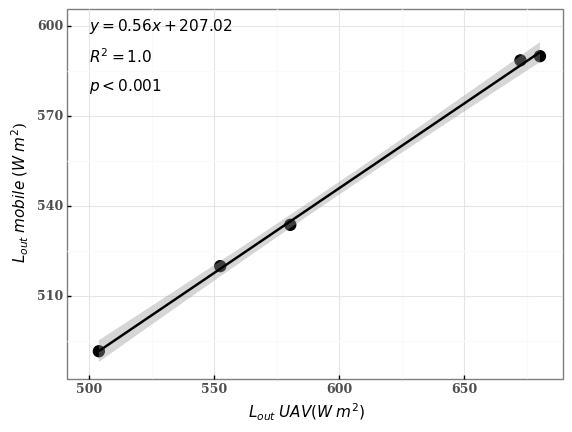

<ggplot: (-9223372019857810748)>

In [12]:
# Let`s remember how linear correlation works: y = a + b*x.
# 'x' is the data I wand to modify, in order to obtain 'y'. The equation gives me how I want to modify it. In this case, 
# I want to modify the drone data in order for it to be equivalent to the mast data. 
# Therefore, 'mast' is the 'y', and 'drone' is the 'x'.

#corr_out_desert_df.plot(x= 'LW_obj', y= 'LWout_W+1m-2_corr', style='o')
#corr_out_desert_df['LW_obj'].corr(corr_out_desert_df['LWout_W+1m-2_corr'])

cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt = ggplot(corr_out_desert_df)
plt = plt + theme_bw()
plt = plt + geom_point(aes(x='median_camera_rad_W+1m-2',y='LWout_W+1m-2_corr'),size=4)
plt = plt + geom_smooth(aes(x='median_camera_rad_W+1m-2',y='LWout_W+1m-2_corr'),method='lm')
plt = plt + labs(x='$L_{out} \; UAV (W\; m^{2})$', y='$L_{out} \; mobile \;(W\; m^{2}$)', parse=True)
plt = plt + theme(axis_text_x=element_text(size=9,weight='bold'),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')

x = corr_out_desert_df['median_camera_rad_W+1m-2']
y = corr_out_desert_df['LWout_W+1m-2_corr']
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(scipy.stats.linregress(x,y))
display(line)

coefficients = pd.DataFrame([scipy.stats.linregress(x, y)])
coefficients['r_text'] = '$R^2 = ' + coefficients['rvalue'].round(2).astype(str) + '$'
coefficients['eq_text'] = '$y = ' + coefficients['slope'].round(2).astype(str) + 'x + ' + coefficients['intercept'].round(2).astype(str) + '$'
coefficients['p_text'] = pvalue_text(coefficients['pvalue'].values[0])
display(coefficients)

plt = plt + geom_text(aes(x=500, y = 590, label='r_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=500, y = 580, label='p_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=500, y = 600, label='eq_text'), data=coefficients, inherit_aes=False, ha='left')

plt.save('drone calibration desert.pdf', width=15, height=10, units='cm', scale=1.3, dpi=600)
plt.save('drone calibration desert.png', width=15, height=10, units='cm', scale=1.3, dpi=600)


plt

In [14]:
# Now, I will correct the drone LW out data based on the mast data, creating a column which is the corrected drone data, 
# and that I will call an artificial high mast ("LW_obj_art_mast"):

corr_out_desert_df['LW_out_art_mast'] = intercept + slope*corr_out_desert_df['median_camera_rad_W+1m-2']

display(corr_out_desert_df)

,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2_old,SWin_W+1m-2,...,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj,delta_LWout_calc,LWout_W+1m-2_corr,LW_out_art_mast
2,20181023_1345,soil,2018-10-23 13:45:00,0.87,35.057372,29.971615,49.949999,399.140000,521.086433,385.847300,...,41.022905,45.980452,35.096683,3.478473,395.661527,520.838789,575.870201,1.110784,519.975649,519.085137
5,20181023_1530,soil,2018-10-23 15:30:00,0.87,35.057318,29.971685,50.341026,418.038072,491.273469,9.594289,...,33.883573,37.830620,29.684575,-0.284057,418.322129,507.730641,516.703472,-0.339517,491.612986,491.671949
160,20190714_1000,soil,2019-07-14 10:00:00,0.87,35.056934,29.971898,49.976596,373.720877,536.551056,851.458780,...,44.924909,56.964514,34.306077,8.134588,365.586289,488.528410,612.528016,2.825997,533.725059,534.891918
163,20190714_1500,soil,2019-07-14 15:00:00,0.87,35.056932,29.971892,49.951021,393.174506,591.367118,847.336117,...,56.842497,68.455735,47.661334,8.093361,385.081145,535.953153,715.348418,2.840332,588.526786,586.854198
166,20190715_1300,soil,2019-07-15 13:00:00,0.87,35.056930,29.971899,49.983673,393.225512,593.381381,1016.563714,...,57.795053,69.745789,49.075587,9.785637,383.439875,521.077250,724.564672,3.455695,589.925686,591.262964


In [18]:
def calculate_Lemitted(Lout, Lin, emissivity):
    Lemitted = Lout - (1 - emissivity)*Lin
    return(Lemitted)

# Now, I need to apply this calibration obtained in the desert to the whole drone data of the pv field:
# First, calculate the LWout
pv_df['LW_out_art_mast'] = intercept + slope * pv_df['median_camera_rad_W+1m-2']
# Second, based on LWout, calculate the surface LW (Lobj)
pv_df['LW_obj_art_mast'] = calculate_Lemitted(pv_df['LW_out_art_mast'], pv_df['LWin_W+1m-2_corr'], pv_df['Emissivity'])

display(pv_df)

,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2,SWin_W+1m-2,...,std_T_apparent_C,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj,LW_out_art_mast,LW_obj_art_mast
6,20181024_1200,panel,2018-10-24 12:00:00,0.84,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,2.883536,45.295196,97.794196,29.234599,6.340116,396.905799,511.555634,618.719404,536.475638,472.970710
7,20181024_1200,shadow,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,2.176472,31.523893,47.291177,26.478492,6.340116,396.905799,511.555634,502.417450,483.078442,431.480689
8,20181024_1200,soil,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,2.456028,42.698219,55.547329,30.684930,6.340116,396.905799,511.555634,589.522718,525.885986,474.288232
9,20181024_1200,sun,2018-10-24 12:00:00,1.00,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,6.354612,34.927399,60.167911,25.071166,6.340116,396.905799,511.555634,416.678016,442.394095,442.394095
10,20181024_1430,panel,2018-10-24 14:30:00,0.84,35.059985,29.966051,49.925984,442.130129,478.864639,49.728499,...,1.974823,35.720349,44.075652,23.794959,0.117285,442.012844,493.548104,530.294740,498.594978,427.872923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,20190723_1430,shadow,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,1.287815,48.103947,52.943099,42.439175,8.776320,408.587579,544.358875,633.233154,548.225155,495.108770
235,20190723_1430,soil,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,1.481591,59.373911,64.981281,48.845973,8.776320,408.587579,544.358875,735.837142,598.649483,545.533098
236,20190723_1715,panel,2019-07-23 17:15:00,0.84,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,0.722314,47.127403,53.768759,37.786303,3.725882,425.012318,545.421616,629.343402,544.057014,476.055043
237,20190723_1715,shadow,2019-07-23 17:15:00,0.87,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,1.134574,44.962954,48.000284,41.953005,3.725882,425.012318,545.421616,603.977596,535.053767,479.802165


## Estimate each object's temperature based on the Stefan-Boltzmann equation.
### note - check if Lior did it in his script. We are missing here the full radiometric equation, that is, deducing the reflected Lin
I want to create a column which will be the temperature of the object based on its LW emission, for a future temperature analysis. For this, I will use at this moment the drone LW, not corrected to the mast LW.

In [19]:
# Constants
sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant

# We are using the simple Stefan Boltzmann equation, and not the full radiometric equation, because this was already applied in the function "object_lw"
    
pv_df['T_object'] = ((pv_df['LW_obj_art_mast']/(pv_df['Emissivity']*sigma))**0.25) - 273.15

display(pv_df.columns.values)
display(pv_df)

pv_df.to_csv('temperature_by_element.csv')

array(['flight', 'label', 'date_time', 'Emissivity', 'Lon', 'Lat',
       'relative_altitude_m', 'LWin_W+1m-2_old', 'LWout_W+1m-2',
       'SWin_W+1m-2', 'SWout_W+1m-2', 'PPFD_umol+1m-2s-1',
       'PPFDr_umol+1m-2s-1', 'Ta_C', 'RH_percent', 'Pa_hPa', 'Rn_W+1m-2',
       'calculated_reflected_rad_W+1m-2', 'mean_camera_rad_W+1m-2',
       'std_camera_rad_W+1m-2', 'median_camera_rad_W+1m-2',
       'max_camera_rad_W+1m-2', 'min_camera_rad_W+1m-2',
       'coverage_percent', 'mean_T_apparent_C', 'std_T_apparent_C',
       'median_T_apparent_C', 'max_T_apparent_C', 'min_T_apparent_C',
       'delta_LWin_calc', 'LWin_W+1m-2_corr', 'LW_atm', 'LW_obj',
       'LW_out_art_mast', 'LW_obj_art_mast', 'T_object'], dtype=object)

,flight,label,date_time,Emissivity,Lon,Lat,relative_altitude_m,LWin_W+1m-2_old,LWout_W+1m-2,SWin_W+1m-2,...,median_T_apparent_C,max_T_apparent_C,min_T_apparent_C,delta_LWin_calc,LWin_W+1m-2_corr,LW_atm,LW_obj,LW_out_art_mast,LW_obj_art_mast,T_object
6,20181024_1200,panel,2018-10-24 12:00:00,0.84,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,45.295196,97.794196,29.234599,6.340116,396.905799,511.555634,618.719404,536.475638,472.970710,42.521814
7,20181024_1200,shadow,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,31.523893,47.291177,26.478492,6.340116,396.905799,511.555634,502.417450,483.078442,431.480689,32.664162
8,20181024_1200,soil,2018-10-24 12:00:00,0.87,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,42.698219,55.547329,30.684930,6.340116,396.905799,511.555634,589.522718,525.885986,474.288232,39.982280
9,20181024_1200,sun,2018-10-24 12:00:00,1.00,35.059971,29.965743,49.901588,403.245915,530.631465,672.011646,...,34.927399,60.167911,25.071166,6.340116,396.905799,511.555634,416.678016,442.394095,442.394095,24.050405
10,20181024_1430,panel,2018-10-24 14:30:00,0.84,35.059985,29.966051,49.925984,442.130129,478.864639,49.728499,...,35.720349,44.075652,23.794959,0.117285,442.012844,493.548104,530.294740,498.594978,427.872923,34.711900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,20190723_1430,shadow,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,48.103947,52.943099,42.439175,8.776320,408.587579,544.358875,633.233154,548.225155,495.108770,43.363623
235,20190723_1430,soil,2019-07-23 14:30:00,0.87,35.059986,29.966017,49.954878,417.363899,607.488439,915.632049,...,59.373911,64.981281,48.845973,8.776320,408.587579,544.358875,735.837142,598.649483,545.533098,51.131766
236,20190723_1715,panel,2019-07-23 17:15:00,0.84,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,47.127403,53.768759,37.786303,3.725882,425.012318,545.421616,629.343402,544.057014,476.055043,43.035199
237,20190723_1715,shadow,2019-07-23 17:15:00,0.87,35.059981,29.966053,49.945652,428.738200,563.045520,410.588180,...,44.962954,48.000284,41.953005,3.725882,425.012318,545.421616,603.977596,535.053767,479.802165,40.888434


## Find the correlation between the corrected drone data (artificial high mast) and the actual mast measurements

Now, I will find the correlation between the corrected drone data (artificial high mast) and the actual mast measurements. I will not correct the LWout at this point, because the mast height is too low, and therefore the SWout is not representing the actual field.

- The shadow flights when the coverage was 0%, or the LW is somehow not real are (['20181025_0630','20181025_0730','20181025_0845','20181025_1000','20181025_1200','20181025_1330','20181025_1615','20181026_0815','20181030_1500','20181031_0630'])
- Before calculating the correlations, I need to obtain one LW value for the whole field, which will be proportional to the LW value of each object wheighted by its coverage percent.

In [20]:
# Remove unrealistic values
pv_df.loc[pv_df['T_object'] < 20, 'LW_out_art_mast'] = 0
pv_df.loc[pv_df['coverage_percent'] < 1, 'LW_out_art_mast'] = 0

# Eliminate from the terms of the calculation
pv_df.loc[pv_df['T_object'] < 20, 'coverage_percent'] = 0
pv_df.loc[pv_df['coverage_percent'] < 1, 'coverage_percent'] = 0


In [21]:
# Weigthed average to find a LW value for the whole picture, based on the coverage percent of each object

out_df = pv_df.pivot(index='date_time', columns='label', values=['LW_out_art_mast','coverage_percent','LWout_W+1m-2','T_object'])
out_df.columns = list(map('_'.join, out_df.columns.values))
out_df = out_df.reset_index()

out_df['total_fraction'] = out_df['coverage_percent_panel']/100  + out_df['coverage_percent_shadow']/100 + out_df['coverage_percent_soil']/100
out_df['LW_art_mast_all_objects'] = out_df['LW_out_art_mast_panel']  * out_df['coverage_percent_panel']/100  / out_df['total_fraction'] + \
                                  out_df['LW_out_art_mast_shadow'] * out_df['coverage_percent_shadow']/100 / out_df['total_fraction'] + \
                                  out_df['LW_out_art_mast_soil']   * out_df['coverage_percent_soil']/100   / out_df['total_fraction']
# the pivot function creates three columns of LWout, separeted by the field elements, but this is not true.
# They are a repetition from the mast LWout measurement. THe "_panel" was abritrarily chosen.
out_df['LWout_truck_mast_uncorr'] = out_df['LWout_W+1m-2_panel'] 

# Create 'Season' column
out_df.loc[out_df['date_time'].dt.year == 2019, 'Season'] = 'Summer'
out_df.loc[out_df['date_time'].dt.year == 2018, 'Season'] = 'Autumn'

display(out_df)
out_df.to_csv('temperature_graph.csv') 

,date_time,LW_out_art_mast_panel,LW_out_art_mast_shadow,LW_out_art_mast_soil,LW_out_art_mast_sun,coverage_percent_panel,coverage_percent_shadow,coverage_percent_soil,coverage_percent_sun,LWout_W+1m-2_panel,...,LWout_W+1m-2_soil,LWout_W+1m-2_sun,T_object_panel,T_object_shadow,T_object_soil,T_object_sun,total_fraction,LW_art_mast_all_objects,LWout_truck_mast_uncorr,Season
0,2018-10-24 12:00:00,536.475638,483.078442,525.885986,0.0,51.156461,29.067579,19.011906,0.0,530.631465,...,530.631465,530.631465,42.521814,32.664162,39.982280,24.050405,0.992359,518.806066,530.631465,Autumn
1,2018-10-24 14:30:00,498.594978,475.873586,498.337562,0.0,49.811822,27.137408,22.596344,0.0,478.864639,...,478.864639,478.864639,34.711900,30.321746,34.315464,-10.449760,0.995456,492.342401,478.864639,Autumn
2,2018-10-24 15:00:00,495.008894,494.050488,506.039937,0.0,50.709343,19.940517,29.229635,0.0,476.432220,...,476.432220,476.432220,34.200336,33.672135,35.754370,-25.871724,0.998795,498.045776,476.432220,Autumn
3,2018-10-24 18:00:00,470.924891,475.439115,480.613721,0.0,51.627161,17.179996,31.076750,0.0,465.069472,...,465.069472,465.069472,31.007627,31.334820,32.259542,-27.339431,0.998839,474.715809,465.069472,Autumn
4,2018-10-25 06:30:00,467.329501,0.000000,469.839229,0.0,48.336351,0.000000,51.521258,0.0,466.216237,...,466.216237,466.216237,29.459496,-29.059890,29.638469,-17.712213,0.998576,468.624389,466.216237,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2019-07-22 15:00:00,580.452303,539.370048,584.495119,NaN,45.834864,4.749707,45.747971,NaN,589.122169,...,589.122169,NaN,49.182552,41.819334,48.895763,NaN,0.963325,580.346648,589.122169,Summer
58,2019-07-23 10:45:00,608.743928,544.341567,580.445182,NaN,47.611869,4.578258,44.360842,NaN,584.081594,...,584.081594,NaN,53.886471,42.934076,48.574916,NaN,0.965510,592.688089,584.081594,Summer
59,2019-07-23 12:45:00,605.507922,546.948961,597.551736,NaN,48.350916,5.686132,42.397159,NaN,605.054013,...,605.054013,NaN,53.268228,43.238313,51.041797,NaN,0.964342,598.557134,605.054013,Summer
60,2019-07-23 14:30:00,598.979574,548.225155,598.649483,NaN,47.203473,5.192622,43.955849,NaN,607.488439,...,607.488439,NaN,52.186156,43.363623,51.131766,NaN,0.963519,596.093717,607.488439,Summer


## Calculating the correlations (separated by season)

### July 2019

'Regression line: y_autumn=199.94+0.63x_autumn, r=0.78'

'Regression line: y_summer=42.01+0.92x_summer, r=0.97'

,Season,slope,intercept,rvalue,pvalue,stderr,r_text,eq_text,p_text
0,Autumn,0.628663,199.935623,0.777211,3.005993e-06,0.103894,$R^2 = 0.78$,$y = 0.63x + 199.94$,$p < 0.001$
0,Summer,0.923038,42.014528,0.969598,6.138852e-15,0.049665,$R^2 = 0.97$,$y = 0.92x + 42.01$,$p < 0.001$


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: lout applying calibration pv.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: lout applying calibration pv.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an e

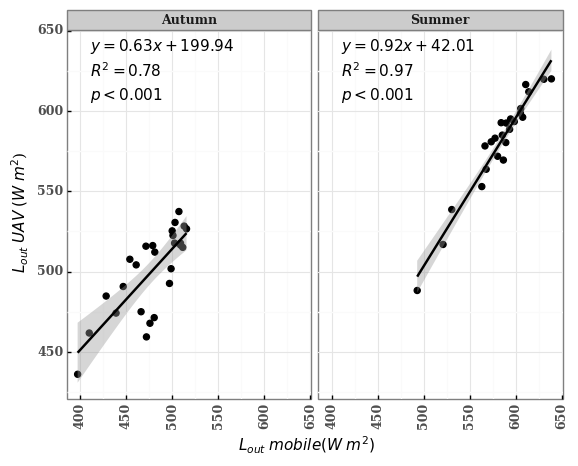

<ggplot: (-9223372019847834072)>

In [22]:
# Defining the correlation equation function: 
# Let`s remember how linear correlation works: y = a + b*x.
# 'x' is the data I wand to modify, in order to obtain 'y'. The equation gives me how I want to modify it.
# In this case, I want to modify the mast data in order for it to be equivalent to the drone data. 
# Therefore, 'drone' ('LW_art_mast_all_objects') is the 'y', and 'mast' ('LWout_truck_mast_uncorr') is the 'x'.

#out_df.loc[out_df['date_time'].dt.year == 2019].plot(x= 'LWout_truck_mast_uncorr', y= 'LW_art_mast_all_objects', style='o')
#out_df['LWout_truck_mast_uncorr'].corr(out_df['LW_art_mast_all_objects'])

# Remove 2 bad days
out_df = out_df.loc[out_df['date_time'] > '2018-10-26'].copy()

cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt = ggplot(out_df)
plt = plt + theme_bw()
plt = plt + geom_point(aes(x = 'LWout_truck_mast_uncorr', y = 'LW_art_mast_all_objects'),size=2)
plt = plt + geom_smooth(aes(x = 'LWout_truck_mast_uncorr', y = 'LW_art_mast_all_objects'),method='lm')
plt = plt + labs(x='$L_{out} \; mobile (W\; m^{2})$', y='$L_{out} \; UAV \;(W\; m^{2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + theme(axis_text_x=element_text(size=9,rotation=90,hjust=0.5,weight='bold'),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')

x_autumn = out_df.loc[out_df['date_time'].dt.year == 2018, 'LWout_truck_mast_uncorr']
y_autumn = out_df.loc[out_df['date_time'].dt.year == 2018, 'LW_art_mast_all_objects']
slope18, intercept18, r, p, stderr = scipy.stats.linregress(x_autumn,y_autumn)
line_autumn = f'Regression line: y_autumn={intercept18:.2f}+{slope18:.2f}x_autumn, r={r:.2f}'
#print(scipy.stats.linregress(x,y))
display(line_autumn)
x_summer = out_df.loc[out_df['date_time'].dt.year == 2019, 'LWout_truck_mast_uncorr']
y_summer = out_df.loc[out_df['date_time'].dt.year == 2019, 'LW_art_mast_all_objects']
slope19, intercept19, r, p, stderr = scipy.stats.linregress(x_summer,y_summer)
line_summer = f'Regression line: y_summer={intercept19:.2f}+{slope19:.2f}x_summer, r={r:.2f}'
#print(scipy.stats.linregress(x,y))
display(line_summer)


coefficients = pd.DataFrame([scipy.stats.linregress(x_autumn, y_autumn)])
coefficients = coefficients.append(pd.DataFrame([scipy.stats.linregress(x_summer, y_summer)]))
coefficients.insert(loc=0, column='Season', value=['Autumn','Summer'])
coefficients['r_text'] = '$R^2 = ' + coefficients['rvalue'].round(2).astype(str) + '$'
coefficients['eq_text'] = '$y = ' + coefficients['slope'].round(2).astype(str) + 'x + ' + coefficients['intercept'].round(2).astype(str) + '$'
coefficients['p_text'] = pvalue_text(coefficients['pvalue'].values[0])
display(coefficients)

plt = plt + geom_text(aes(x=410, y = 625, label='r_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=410, y = 640, label='eq_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=410, y = 610, label='p_text'), data=coefficients, inherit_aes=False, ha='left')

plt.save('lout applying calibration pv.pdf', width=15, height=10, units='cm', scale=1.3, dpi=600)
plt.save('lout applying calibration pv.png', width=15, height=10, units='cm', scale=1.3, dpi=600)


plt

### October 2018

In [23]:
# This shows the values that are more than 20 W m-s away from the correlation with the drone

out_df.loc[(intercept18 + slope18*out_df['LWout_truck_mast_uncorr'] - 20) > out_df['LW_art_mast_all_objects']]

,date_time,LW_out_art_mast_panel,LW_out_art_mast_shadow,LW_out_art_mast_soil,LW_out_art_mast_sun,coverage_percent_panel,coverage_percent_shadow,coverage_percent_soil,coverage_percent_sun,LWout_W+1m-2_panel,...,LWout_W+1m-2_soil,LWout_W+1m-2_sun,T_object_panel,T_object_shadow,T_object_soil,T_object_sun,total_fraction,LW_art_mast_all_objects,LWout_truck_mast_uncorr,Season
12,2018-10-26 08:15:00,459.949622,0.00000,458.875970,0.0,47.884971,0.000000,51.821440,0.0,471.868595,...,471.868595,471.868595,30.186706,-29.224840,29.302676,-8.402888,0.997064,459.391602,471.868595,Autumn
23,2018-10-28 15:45:00,477.836351,438.23728,466.972408,0.0,49.910007,3.550656,46.201350,0.0,480.306932,...,480.306932,480.306932,33.768238,25.680964,30.994451,-16.821531,0.996620,471.389245,480.306932,Autumn
30,2018-10-30 15:00:00,467.497511,0.00000,468.260518,0.0,50.551081,0.000000,49.221993,0.0,475.688833,...,475.688833,475.688833,31.479922,-31.637305,30.915347,-12.734963,0.997731,467.873932,475.688833,Autumn
51,2019-07-20 21:00:00,477.427284,0.00000,498.532308,NaN,46.710205,0.000000,49.445926,NaN,492.815210,...,492.815210,NaN,31.916382,31.008042,35.172690,NaN,0.961561,488.280023,492.815210,Summer


,date_time,LW_out_art_mast_panel,LW_out_art_mast_shadow,LW_out_art_mast_soil,LW_out_art_mast_sun,coverage_percent_panel,coverage_percent_shadow,coverage_percent_soil,coverage_percent_sun,LWout_W+1m-2_panel,...,LWout_W+1m-2_sun,T_object_panel,T_object_shadow,T_object_soil,T_object_sun,total_fraction,LW_art_mast_all_objects,LWout_truck_mast_uncorr,Season,LWout_truck_mast_corr
12,2018-10-26 08:15:00,459.949622,0.000000,458.875970,0.0,47.884971,0.000000,51.821440,0.0,471.868595,...,471.868595,30.186706,-29.224840,29.302676,-8.402888,0.997064,459.391602,471.868595,Autumn,496.582146
13,2018-10-26 11:00:00,544.380332,475.345043,514.978484,0.0,50.601526,30.625951,18.045624,0.0,502.471469,...,502.471469,45.084540,32.393758,39.203934,34.418864,0.992731,517.738210,502.471469,Autumn,515.821054
14,2018-10-26 13:30:00,536.772045,473.349492,514.668552,0.0,49.293491,32.394703,17.541438,0.0,480.976046,...,480.976046,43.905866,32.098118,39.207916,-20.446376,0.992296,512.159621,480.976046,Autumn,502.307668
15,2018-10-26 15:30:00,481.779866,461.738809,468.817414,0.0,48.328134,12.664815,38.543816,0.0,438.848449,...,438.848449,34.805685,30.312918,31.588483,-13.276977,0.995368,474.210415,438.848449,Autumn,475.823589
16,2018-10-27 08:00:00,495.282021,448.215141,472.165582,0.0,49.509133,35.813791,14.018068,0.0,466.036509,...,466.036509,37.537264,28.116879,32.460847,-7.358171,0.993410,475.051790,466.036509,Autumn,492.915728
17,2018-10-27 12:00:00,557.100921,467.786770,519.479517,0.0,50.917379,31.222243,17.253932,0.0,500.718808,...,500.718808,47.588487,31.456158,40.329616,42.844111,0.993936,522.514118,500.718808,Autumn,514.719220
18,2018-10-27 13:00:00,559.668064,470.047612,525.246291,0.0,50.304338,31.128324,17.838383,0.0,499.855158,...,499.855158,47.898329,31.771232,41.192311,43.160075,0.992710,525.380491,499.855158,Autumn,514.176275
19,2018-10-27 15:45:00,505.186141,465.623917,493.958295,0.0,49.855164,31.014224,18.595868,0.0,446.612148,...,446.612148,38.814218,30.918085,35.901740,-9.124337,0.994653,490.751119,446.612148,Autumn,480.704342
20,2018-10-28 09:15:00,538.447450,463.206224,502.069086,0.0,49.318258,31.801305,17.882627,0.0,453.838824,...,453.838824,44.774368,30.806742,37.589393,-1.925778,0.990022,507.707626,453.838824,Autumn,485.247489
21,2018-10-28 10:30:00,547.106136,468.764057,512.683597,0.0,50.986032,31.943685,16.460692,0.0,478.701658,...,478.701658,46.045397,31.684169,39.254789,43.426677,0.993904,516.226360,478.701658,Autumn,500.877843


<AxesSubplot:xlabel='LWout_truck_mast_uncorr'>

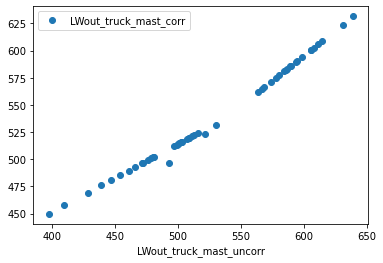

In [24]:
# Applying correlation to obtain corrected truck mast data
# Each campaign will be corrected according to its own correlation equation:

out_df['LWout_truck_mast_corr'] = np.nan
out_df.loc[out_df['date_time'].dt.year == 2019, 'LWout_truck_mast_corr'] = intercept19 + slope19*out_df.loc[out_df['date_time'].dt.year == 2019, 'LWout_truck_mast_uncorr']
out_df.loc[out_df['date_time'].dt.year == 2018, 'LWout_truck_mast_corr'] = intercept18 + slope18*out_df.loc[out_df['date_time'].dt.year == 2018, 'LWout_truck_mast_uncorr']

display(out_df)
out_df.to_csv('checking_corr.csv') 

out_df.plot(x= 'LWout_truck_mast_uncorr', y='LWout_truck_mast_corr', style='o')

With the previous step, we managed to see that the correlation works. But it was only for the half hours
close to the drone flights. We still need to apply it for the whole dataset.

Now I will load the full truck dataset (from Tovi, and after the SW effect correction on LW) in order to correct the LWout of the mast, based on the equation obtained above:

In [25]:
truck_df = pd.read_csv('Ketura_all_corr.csv')
truck_df['DateTime'] = pd.to_datetime(truck_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)

truck_df = truck_df.loc[(truck_df['Ecosystem'] == 'Solar') & (truck_df['Month'] != 'March')].copy()

display(truck_df)

,DateTime,Month,Year,Ecosystem,H,LE,PA_average,RH,TA_average,VPD,H2O,PARin,PARout,SW_IN_average,SW_OUT_average,LW_IN_average_corr,LW_OUT_average_corr,albedo,WS_average,Tsonic
859,2019-07-16 14:30:00+00:00,July,2019,Solar,304.8530,28.7057,99364.900000,16.350000,311.230000,5550.510000,10.91530,1886.99000,484.05100,911.461000,275.647000,404.976390,603.234530,0.302423,1.662850,316.079
860,2019-07-16 15:00:00+00:00,July,2019,Solar,366.4210,44.6383,99346.200000,16.250000,311.580000,5663.120000,11.05750,1723.37000,449.39400,842.765000,255.137000,406.853350,597.420630,0.302738,2.977150,316.438
861,2019-07-16 15:30:00+00:00,July,2019,Solar,291.7220,16.2617,99326.000000,15.730000,311.930000,5806.680000,10.90950,1534.24000,406.75700,759.093000,230.176000,409.409070,595.230240,0.303225,2.503800,316.895
862,2019-07-16 16:00:00+00:00,July,2019,Solar,314.4480,20.2474,99307.200000,16.280000,312.000000,5790.530000,11.33560,1322.34000,355.75100,663.480000,201.063000,412.505200,586.527370,0.303043,1.989260,317.407
863,2019-07-16 16:30:00+00:00,July,2019,Solar,208.7610,20.6301,99298.000000,16.480000,312.060000,5795.350000,11.51300,1107.51000,306.27200,564.169000,172.939000,412.925310,576.862610,0.306538,1.965150,317.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2018-11-01 05:30:00+00:00,October,2018,Solar,NaN,NaN,100471.587965,20.850000,296.980000,2330.880000,6.10747,5.75276,1.41498,0.567066,0.255847,328.685329,409.699442,0.451177,1.110450,296.730
1842,2018-11-01 06:00:00+00:00,October,2018,Solar,NaN,NaN,100486.503397,20.320000,297.530000,2425.200000,6.15097,73.03590,18.80520,35.924300,11.733400,328.489757,411.425666,0.326615,1.933790,295.985
1843,2018-11-01 06:30:00+00:00,October,2018,Solar,NaN,NaN,100509.489886,19.690000,298.240000,2550.230000,6.21678,236.23700,52.97830,125.386000,32.040400,328.038140,418.312596,0.255534,1.838250,296.366
1844,2018-11-01 07:00:00+00:00,October,2018,Solar,NaN,NaN,100494.656989,23.862959,296.241914,2243.710000,6.19462,NaN,NaN,212.404074,56.959081,330.898376,417.273285,0.268164,1.570320,297.079


### Applying the correction to the full truck dataset on the PV field:

In [26]:
truck_df['LWout_corr_bydrone'] = np.nan
truck_df.loc[truck_df['DateTime'].dt.year == 2019, 'LWout_corr_bydrone'] = intercept19 + slope19*truck_df.loc[truck_df['DateTime'].dt.year == 2019, 'LW_OUT_average_corr']
truck_df.loc[truck_df['DateTime'].dt.year == 2018, 'LWout_corr_bydrone'] = intercept18 + slope18*truck_df.loc[truck_df['DateTime'].dt.year == 2018, 'LW_OUT_average_corr']

truck_df.drop('Month', axis=1, inplace=True)

display (truck_df)

,DateTime,Year,Ecosystem,H,LE,PA_average,RH,TA_average,VPD,H2O,PARin,PARout,SW_IN_average,SW_OUT_average,LW_IN_average_corr,LW_OUT_average_corr,albedo,WS_average,Tsonic,LWout_corr_bydrone
859,2019-07-16 14:30:00+00:00,2019,Solar,304.8530,28.7057,99364.900000,16.350000,311.230000,5550.510000,10.91530,1886.99000,484.05100,911.461000,275.647000,404.976390,603.234530,0.302423,1.662850,316.079,598.823025
860,2019-07-16 15:00:00+00:00,2019,Solar,366.4210,44.6383,99346.200000,16.250000,311.580000,5663.120000,11.05750,1723.37000,449.39400,842.765000,255.137000,406.853350,597.420630,0.302738,2.977150,316.438,593.456573
861,2019-07-16 15:30:00+00:00,2019,Solar,291.7220,16.2617,99326.000000,15.730000,311.930000,5806.680000,10.90950,1534.24000,406.75700,759.093000,230.176000,409.409070,595.230240,0.303225,2.503800,316.895,591.434760
862,2019-07-16 16:00:00+00:00,2019,Solar,314.4480,20.2474,99307.200000,16.280000,312.000000,5790.530000,11.33560,1322.34000,355.75100,663.480000,201.063000,412.505200,586.527370,0.303043,1.989260,317.407,583.401679
863,2019-07-16 16:30:00+00:00,2019,Solar,208.7610,20.6301,99298.000000,16.480000,312.060000,5795.350000,11.51300,1107.51000,306.27200,564.169000,172.939000,412.925310,576.862610,0.306538,1.965150,317.320,574.480736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2018-11-01 05:30:00+00:00,2018,Solar,NaN,NaN,100471.587965,20.850000,296.980000,2330.880000,6.10747,5.75276,1.41498,0.567066,0.255847,328.685329,409.699442,0.451177,1.110450,296.730,457.498674
1842,2018-11-01 06:00:00+00:00,2018,Solar,NaN,NaN,100486.503397,20.320000,297.530000,2425.200000,6.15097,73.03590,18.80520,35.924300,11.733400,328.489757,411.425666,0.326615,1.933790,295.985,458.583888
1843,2018-11-01 06:30:00+00:00,2018,Solar,NaN,NaN,100509.489886,19.690000,298.240000,2550.230000,6.21678,236.23700,52.97830,125.386000,32.040400,328.038140,418.312596,0.255534,1.838250,296.366,462.913449
1844,2018-11-01 07:00:00+00:00,2018,Solar,NaN,NaN,100494.656989,23.862959,296.241914,2243.710000,6.19462,NaN,NaN,212.404074,56.959081,330.898376,417.273285,0.268164,1.570320,297.079,462.260072


In [27]:
truck_df.to_csv(output_path + 'final_truck_LWout_corrected.csv') 